In [2]:

import pandas as pd
from pathlib import Path
from sad2_final_project.analysis import add_missing_metrics_from_experiment, loader_obsolete_data
import os

# paths
## set global dir
cwd=Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent) 
print(os.getcwd())
## create paths 
DATA_PATH = Path('data/trajectory_length_vs_attractors')

df = loader_obsolete_data(DATA_PATH / 'results/metadata.csv', DATA_PATH / 'results/joined_results_trajectory_length_vs_attractors.csv')
metrics_list=['TP', 'FP', 'FN', 'precision', 'recall', 'sensitivity', 'AHD', 'SHD', 'EHD', 'SID']
df = add_missing_metrics_from_experiment(df, DATA_PATH, metrics_list, after_column='attractor_ratio')

/home/asia/rok3/sad2/final_project/SAD2_final_project
[Progress] 1/5400 conditions completed (0.0%)
[Progress] 2/5400 conditions completed (0.0%)
[Progress] 3/5400 conditions completed (0.1%)
[Progress] 4/5400 conditions completed (0.1%)
[Progress] 5/5400 conditions completed (0.1%)
[Progress] 6/5400 conditions completed (0.1%)
[Progress] 7/5400 conditions completed (0.1%)
[Progress] 8/5400 conditions completed (0.1%)
[Progress] 9/5400 conditions completed (0.2%)
[Progress] 10/5400 conditions completed (0.2%)
[Progress] 11/5400 conditions completed (0.2%)
[Progress] 12/5400 conditions completed (0.2%)
[Progress] 13/5400 conditions completed (0.2%)
[Progress] 14/5400 conditions completed (0.3%)
[Progress] 15/5400 conditions completed (0.3%)
[Progress] 16/5400 conditions completed (0.3%)
[Progress] 17/5400 conditions completed (0.3%)
[Progress] 18/5400 conditions completed (0.3%)
[Progress] 19/5400 conditions completed (0.4%)
[Progress] 20/5400 conditions completed (0.4%)
[Progress] 21/5

In [3]:
from sad2_final_project.analysis.analysis import plot_boxplot, plot_histogram

## Part 1 

### Numerical analysis of Bnfinder
#### Task
Construct several Boolean networks with sizes (measured by the number of nodes or variables) ranging from 5 to 16.† Each node should have no more than three parent nodes, and the Boolean functions governing individual nodes should be generated at random.

#### Goal
The goal of this study is to determine how the type and amount of time-series data generated from Boolean network dynamics affect the accuracy of dynamic Bayesian network (DBN) structure inference. In particular, we aim to identify:
- how the presence of attractor states in trajectories influences reconstruction accuracy,
- how trajectory length, sampling frequency, and the number of trajectories affects model metrics
- how these effects depend on network size and update dynamics,
- which data-generation techniques yield stable and informative reconstructions. 

---

#### Sets

To ensure reproducibility and comparisons, experiments are organized into predefined sets.
##### Groups
1. **Network size groups**
   Networks are grouped by number of nodes (every 2 from 4 to 16) to analyze scaling behavior.
2. **Update mode groups**
   Synchronous and asynchronous updates are treated separately, as they correspond to different stochastic processes (deterministic map vs stochastic transition system).
   <!-- sprawdzić  -->
3. **Scoring function groups**
<!-- TODO MICHAŁ: tutaj rozwiną o scoring functions -->
   MDL and BDe are analyzed independently. Absolute score values are not compared across scoring functions; only trends with respect to accuracy are considered.
4. **Random function sets**
   For each experimental condition, multiple independently generated Boolean networks are used.
   Random seeds are fixed per network/experiment (TODO ?) instance so that different data-generation parameters (sampling frequency, trajectory length, number of trajectories) are evaluated on identical underlying networks.
   <!-- is not possible we just need to use seed to experiments are reproducle -->

---

##### Averaging and Distributions

**Sample size normalization.**

To ensure fair comparison across different trajectory lengths, we normalize by $n_{\text{trajectories}}$ by:

$$n_{\text{trajectories}}^{\text{norm}} = \left\lceil \frac{n_{\text{nodes}} \cdot n}{L} \right\rceil$$

where:
- $n_{\text{nodes}}$ is the number of nodes in the Boolean network
- $L$ is the trajectory length
- $n$ is a normalization coefficient specifying the desired number of observations per node

This ensures that the total number of observations ($n_{\text{trajectories}} \times L$) remains approximately constant at $n_{\text{nodes}} \cdot n$, providing consistent statistical power across different trajectory lengths and unbiasdness in different conditions. We set $n = 100$, ensuring at least **10 observations per edge** (accounting for up to 3 parents per node on average we can maximally achieve $2^3$ edges). This conservative choice guarantees sufficient data for reliable network inference.

**distributions**

All reported results are based on **distributions**, not single values.
Depending on the experiment, averaging is performed over:

- trajectories (within a dataset),
- independent datasets,
- independently generated networks.

The aggregation strategy is explicitly chosen for each experiment to match the source of variability under investigation.

##### 1. Relation Between Trajectory Length and Entering Attractors

**Objective.**
To characterize how trajectory length is related to the probability of entering attractors as a function of network size and dynamics.

**Experimental design.**

- The target attractor proportion is **not controlled**; trajectories evolve naturally.
- Trajectory lengths are varied in increments proportional to network size:
    - from 10 steps to 50 by 10
- Networks are grouped by size (from 4 to 16 nodes, in steps of two).
- The number of parents per node is randomly chosen from set of $\{1,2,3\}$ to avoid conditioning results on a fixed connectivity pattern.

**Measured quantities.**

- Probability of reaching an attractor as a function of trajectory length.
- How different groups (below TODO - inner link) differ in in this probability.

**Rationale.**
Attractor entry is an emergent property of the dynamics. Controlling it directly is undesirable, as it would introduce selection bias. This experiment instead characterizes the **natural scaling behavior** of Boolean network dynamics.

In [5]:
# Global parameters
NUM_NODES = [i for i in range(5, 17, 2)] # od 5 do 15 (włącznie) wierzchołków, co dwie krawędzie
SCORE_FUNCTIONS = ["MDL", "BDE"]
UPDATE_MODE = ["synchronous", "asynchronous"]
N_PARENT_PER_NODE = [[1, 2, 3]]
N_REPETITIONS = 30 

In [7]:
# create experiments:
## case: Relation between trajectory length and entering attractors
exp_trajectory_length = BooleanNetworkExperiment(
    ### paths
    data_path=DATA_PATH,
    experiment_name='trajectory_length_vs_attractors',
    
    ### Tested variables 
    trajectory_length=[10, 15, 20, 30, 40, 50],
    n_trajectories=[100], 
    sampling_frequency=[1, 2, 3, 4, 5],

    ### Constant values per experiment 
    n_repetitions=30,
    n_parents_per_node=N_PARENT_PER_NODE,

    ### Groups (bo wszędzie takie same)
    num_nodes=NUM_NODES,
    score_functions = SCORE_FUNCTIONS,
    update_mode=UPDATE_MODE,

    simulate_trajectories_to_csv_kwargs = {
            # "sampling_frequency": 1,
            "target_attractor_ratio": 0.5,  # Approximate fraction of trajectory in attractor (0-1)
            "tolerance": 0.125,               # Allowed deviation from the calculated entrance step (0-1)
        }
)
# standardize sample  
exp_trajectory_length.normalize_sample(100) # WAŻNE NORMALIZUJE PRÓBĘ 
exp_trajectory_length.show_experiment_df()

# trzeba zrbić funkcje która nam ustawia względem trajektori n_trajectorii trajectory lenght * n_trajectories / k = num_nodes * 100 i tym k dzielimy n_trajectories i dajemy int'a 

,num_nodes,update_mode,trajectory_length,n_trajectories,sampling_frequency,score_function,n_parents_per_node,rep_id,condition_id,success,attractor_ratio
0,5,synchronous,10,50,1,MDL,"[1, 2, 3]",0,0000,False,NaN
1,5,synchronous,10,50,1,MDL,"[1, 2, 3]",1,0001,False,NaN
2,5,synchronous,10,50,1,MDL,"[1, 2, 3]",2,0002,False,NaN
3,5,synchronous,10,50,1,MDL,"[1, 2, 3]",3,0003,False,NaN
4,5,synchronous,10,50,1,MDL,"[1, 2, 3]",4,0004,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
21595,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",25,21595,False,NaN
21596,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",26,21596,False,NaN
21597,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",27,21597,False,NaN
21598,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",28,21598,False,NaN


In [ ]:
exp_trajectory_length.run_experiment(n_jobs=1)

##### 2. Impact of Sampling Frequency

**Objective.**
To determine how temporal subsampling affects autocorrelation, effective sample size, and reconstruction accuracy.

Dynamic Bayesian network inference assumes conditional independence of observations given parent states in the previous time slice. Excessive temporal dependence violates this assumption in practice by introducing redundant observations.

**Experimental design.**

- For fixed networks and trajectory lengths, datasets are generated using multiple sampling frequencies (1, 2, 3, 4, 5).
- For each dataset
    - ACF and ESS are computed,
    - MDL and BDe scores are extracted from BNFinder2 logs,

**Analysis.**
Accuracy is analyzed jointly as a function of: 
<!-- What does it mean jointly ?? -->

* sampling frequency,
* ESS,
* scoring function (MDL or BDe).

**Rationale.**
This experiment identifies sampling regimes that balance reduced autocorrelation against loss of dynamic information due to over-subsampling.

---

<class 'pandas.core.series.Series'>
(5400,)


/home/asia/rok3/sad2/final_project/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:253: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(data=df, x=x, y=y, hue=hue, palette=palette, ax=ax)


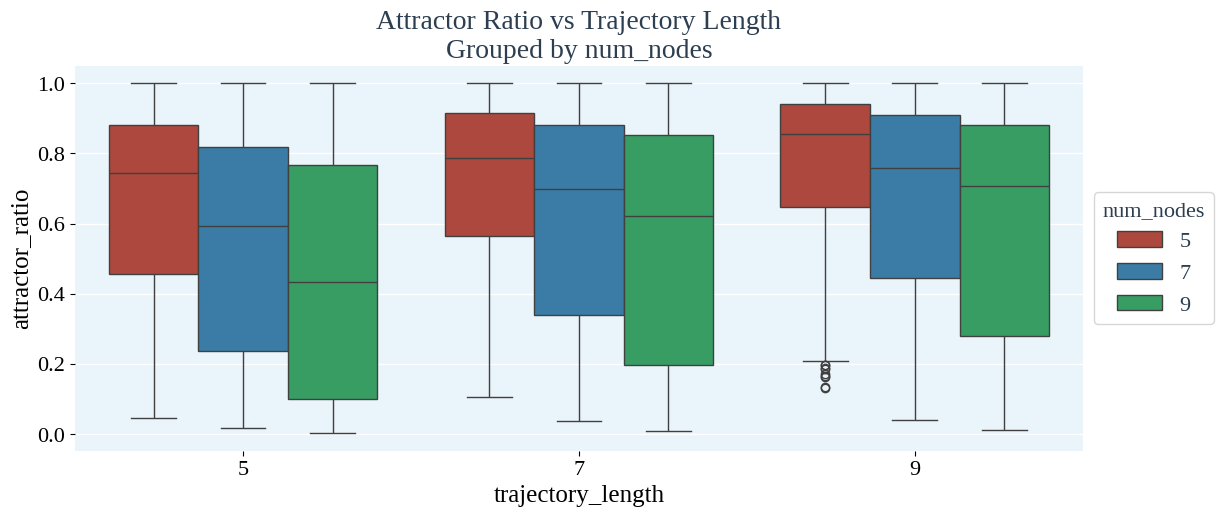

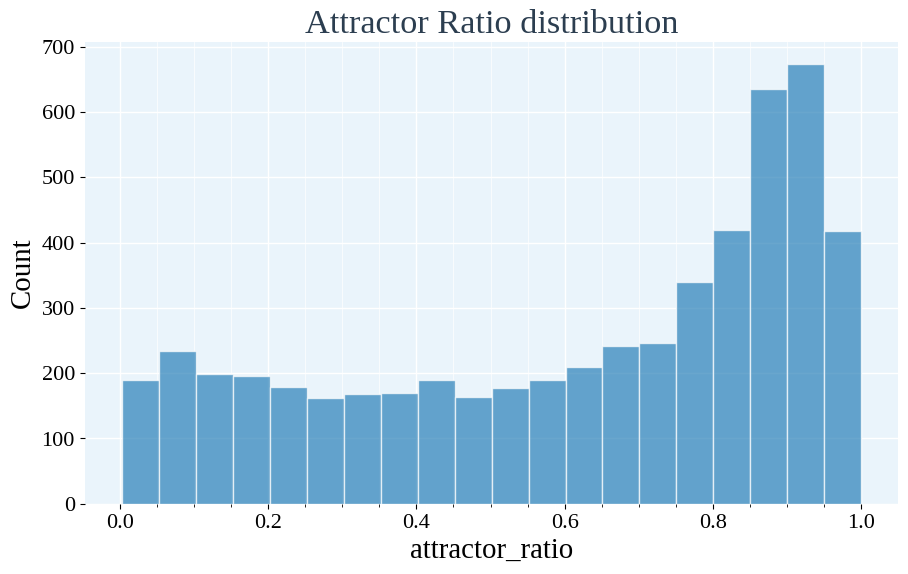

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# ---------------------------
# Global style
# ---------------------------
rcParams['font.family'] = 'Liberation Serif'
rcParams['font.size'] = 16
rcParams['text.color'] = '#2C3E50'
print(type(df['attractor_ratio']))
print(df['attractor_ratio'].shape)

# example category colors
category_colors = ['#C0392B', '#2980B9', '#27AE60', '#F4D03F', '#8E44AD']


# Boxplot grouped by num_nodes
plot_boxplot(df, x='trajectory_length', y='attractor_ratio', hue='num_nodes',
             title='Attractor Ratio vs Trajectory Length\nGrouped by num_nodes')


plot_histogram(df, x='attractor_ratio', title='Attractor Ratio distribution')

In [63]:
unique = df["n_trajectories"].unique()
print(unique)
check = df[df["n_trajectories"]< 50]
check.head()

[ 50  34  25  17  13  10  70  47  35  24  18  14  90  60  45  30  23 110
  74  55  37  28  22 130  87  65  44  33  26]


,dataset,score,dataset_succeeded,attractor_ratio,TP,FP,FN,precision,recall,sensitivity,...,Unnamed: 0,num_nodes,update_mode,trajectory_length,n_trajectories,sampling_frequency,score_function,n_parents_per_node,rep_id,condition_id
300,300,MDL,False,0.866013,10.0,2.0,1.0,0.833333,0.909091,0.909091,...,300,5,synchronous,15,34,1,MDL,"[1, 2, 3]",0,300
301,301,MDL,False,0.886928,5.0,5.0,2.0,0.500000,0.714286,0.714286,...,301,5,synchronous,15,34,1,MDL,"[1, 2, 3]",1,301
302,302,MDL,False,0.873856,4.0,2.0,3.0,0.666667,0.571429,0.571429,...,302,5,synchronous,15,34,1,MDL,"[1, 2, 3]",2,302
303,303,MDL,False,0.913725,7.0,3.0,2.0,0.700000,0.777778,0.777778,...,303,5,synchronous,15,34,1,MDL,"[1, 2, 3]",3,303
304,304,MDL,False,0.798693,6.0,3.0,3.0,0.666667,0.666667,0.666667,...,304,5,synchronous,15,34,1,MDL,"[1, 2, 3]",4,304


##### 3. Amount of Trajectories Required for Stable Inference

**Objective.**
To determine how many independent trajectories are required to obtain statistically stable reconstructions.

**Experimental design.**

- Sampling frequency and trajectory length are fixed to values identified as near-optimal in previous experiments.
- The number of trajectories per dataset is gradually increased - from 10 to 100 by 10.
- For each setting, multiple (30) independent repetitions are performed to obtain convergent distribution .

**Evaluation.**

- Reconstruction accuracy is summarized using distributions (score functions).
- Stability is assessed by observing convergence of accuracy metrics as the number of trajectories increases.
- No classical parametric hypothesis test is assumed; instead, convergence trends is reported.
<!-- Nie znalazłem żadnego sensownego -->

**Rationale.**
Due to the randomness of Boolean functions and initial states, averaging over multiple networks is necessary to separate systematic effects from instance-specific variability.


In [ ]:
# create experiments:
## case: Relation between trajectory length and entering attractors
exp_trajectory_length = BooleanNetworkExperiment(
    ### paths
    data_path=DATA_PATH,
    experiment_name='trajectory_length_vs_attractors',
    
    ### Tested variables 
    trajectory_length=list(30), # TODO TESTS: SET VALUE 
    n_trajectories=[50],
    sampling_frequency=[1], #TODO TESTS: SET VALUE 

    ### Constant values per experiment 
    n_repetitions=N_REPETITIONS,
    n_parents_per_node=N_PARENT_PER_NODE,

    ### Groups (bo wszędzie takie same)
    num_nodes=NUM_NODES,
    score_functions = SCORE_FUNCTIONS,
    update_mode=UPDATE_MODE,

    simulate_trajectories_to_csv_kwargs = {
            # "sampling_frequency": 1,
            "target_attractor_ratio": 0.5,  # Approximate fraction of trajectory in attractor (0-1)
            "tolerance": 0.5,               # Allowed deviation from the calculated entrance step (0-1)
        }
) 
exp_trajectory_length.show_experiment_df()

#### Analysis

In [ ]:
# ANALIZA - będziemy robić do wszystkie wstępny opis po co jakie ploty i potem robić ploty i potem je omawiać 

## Part 2

## 1. Choose validated Boolean network
### Task
Our task is to consider a validated Boolean network model of a real-life biological mechanism. To this end, select a Boolean network 2 model of your choice from the ‘models’ subfolder of the Biodivine repository, available at https://github.com/sybila/biodivine-boolean-models, with the number of nodes (variables) not exceeding 16.‡.
### Dataset
We have chosen to analise the model 'model_id_37' available in the Biodivine repository. This model consists of 11 nodes and 5 inputs and represents a biological mechanism suitable for our network inference task - targeted breast cancer therapy and individual drug response in different breast cancer cell types.


In [3]:
from sad2_final_project.boolean_bn import load_bnet_to_BN

chosen_model = 'model_id_37'
model = load_bnet_to_BN(MODELS_PATH / chosen_model / 'model.bnet')

Loaded 16 nodes. Mapping:
  x0: v_AKT
  x1: v_EGF
  x2: v_ERBB1
  x3: v_ERBB2
  x4: v_ERBB3
  x5: v_ERK1_2
  x6: v_HRG
  x7: v_MEK1_2
  x8: v_PDK1
  x9: v_PKCa
  x10: v_PLCg
  x11: v_erlotinib
  x12: v_mTOR
  x13: v_p70S6K
  x14: v_pertuzumab
  x15: v_trastuzumab
eee


KeyboardInterrupt: 

## 2. Generate dataset
#### Task
Using the insights gained from the first part of the project,
generate an appropriate dataset for the network inference task. 




In [ ]:
NUM_NODES_FINAL = [0]
SCORE_FUNCTIONS_FINAL = ["MDL", "BDE"]
UPDATE_MODE_FINAL = ["synchronous", "asynchronous"]
N_PARENT_PER_NODE_FINAL = [[1, 2, 3]]

Loaded 16 nodes. Mapping:
  x0: v_AKT
  x1: v_EGF
  x2: v_ERBB1
  x3: v_ERBB2
  x4: v_ERBB3
  x5: v_ERK1_2
  x6: v_HRG
  x7: v_MEK1_2
  x8: v_PDK1
  x9: v_PKCa
  x10: v_PLCg
  x11: v_erlotinib
  x12: v_mTOR
  x13: v_p70S6K
  x14: v_pertuzumab
  x15: v_trastuzumab
eee


KeyboardInterrupt: 

## 3. Reconstruct the network with BNFinder2
### Task
Reconstruct the network structure with BNFinder2, applying a scoring function chosen based on your previous
experience. Evaluate the accuracy of the reconstruction.

In [1]:
# TODO MAX: raport zliczenie jakości dopasowania
from sad2_final_project.bnfinder.metrics import evaluate_results_metrics

results = evaluate_results_metrics('tmp', 'tmp', metrics_list=['TP', 'FP', 'TN', 'presicion', 'recall', 'sensitivity', 'AHD', 'SHD', 'EHD', 'SID'])


Informacja do tych sieci do eksperymentów numerycznych
- grupy
    - synchroniczne / asynchroniczne
    - ilość wierzchołków
    - funkcje optymalizacji 
- zmienne latentne
    - wpadania do atraktorów 
    - za
- zmienne kontrolowane 
    - długość trajektorii 
    - ilość trajektorii 
    - ilość prób (do stworzenia rozkładu) 
- stałe
    - ilość rodziców na wierzchołek, (to musi byc losowe, badanie tego typu jest pytaniem ilośc atraktorów $\sim$ ilość rodziców - nie interesuje nas to)



UWAGA
- dodać flage to experimentu, z usuwaniem folderów (testow można puścić wtedy) 

Klasy do robienia analiz (osobne skrypty)
- analysis
    - klasa która przyjmuje metadane, oraz zintegrowane wyniki eksperymentu
    - będzie ona robić wszystkie zliczenia grupowania itd. 
- visualization
    - klasa która będzie brać klasę z analysis 
